## Benchmarking


I'm using this code to benchmark underlying function and my code generation tactics

will use a 2B1T + FWTD model and relise it at 20 m/s & 5 deg aoa

In [1]:
import sympy as sym
import sympy.physics.mechanics as me
from sympy.abc import t as time
import pandas as pd
import seaborn as sns

import numpy as np
from scipy.integrate import odeint,LSODA,BDF,solve_ivp
import matplotlib.pyplot as plt

import sys, os

sys.path.insert(1, os.path.join(sys.path[0], '../..'))
import custom_plot_objects as cpo

import ModelFramework as mf
import ModelFramework.Elements as ele
import ModelFramework.ExternalForces as ef

me.mechanics_printing()

### Define the Model

#### Create Parameter instance

In [2]:
half = sym.Rational(1,2)

# lets go for B2T2 (so 5 DoF)
p = mf.ModelParameters.DynamicModel(2)


## Create some global parameters
p.c = mf.ModelSymbol(value = 0.15,string = 'c') # chord of wing

p.m = mf.ModelSymbol(value = 1,string = 'm')
p.m_w = mf.ModelSymbol(value = 4,string = 'm_w')
p.s = mf.ModelSymbol(value = 1,string = 's') # chord of wing

p.k = (2*2*sym.pi)**2*(p.m_w+p.m)
p.I_xx = 0#sym.Rational(1,12)*p.m*p.s**2*1

p.Lambda = mf.ModelSymbol(value = np.deg2rad(10),string = 'Lambda')
p.rho = mf.ModelSymbol(value = 1.225,string = 'rho') # density
p.V = mf.ModelSymbol(value = 10,string = 'V') # velocity
p.g  = mf.ModelSymbol(value = 9.81,string = 'g') # gravity
p.alpha_r = mf.ModelSymbol(value = np.deg2rad(3),string = 'alpha_r') # root AoA
p.M_thetadot = mf.ModelSymbol(value = 1.2,string = 'M_thetadot')

p.alpha_1 = mf.ModelSymbol(value = 0,string = 'alpha_1') # FWT alpha
p.alphadot_1 = mf.ModelSymbol(value = 0,string = 'alphadot_1') # FWT alphadot


## FWTD Structural Parameters
p.y_0 = sym.Symbol('y_0')
p.x_0 = sym.Symbol('x_0')


## Numeric Model Constants
p.fp = mf.ModelMatrix(value =[0]*p.qs*2,symbols=sym.symbols(f'qtilde:{p.qs*2}')) # The stationary point

## Main Wing Specific
p.a_0 = mf.ModelSymbol(value = 2*np.pi,string = 'a_0') # C_L of wing
## FWT Specific
p.a = p.a_0 - p.a_0/p.s*p.y_0

p.alpha_fwt = mf.ModelSymbol(value = 0,string = 'alpha_1') # FWT alpha
p.alphadot_fwt = mf.ModelSymbol(value = 0,string = 'alphadot_1') # FWT alphadot

#### Create Transforms

In [3]:
#define wrefernce frames
wing_root_frame = mf.HomogenousTransform().Translate(0,0,p.q[1]).R_x(-p.q[0])
wing_aero_frame = wing_root_frame.Translate(0,p.y_0,0)
wing_com_frame = wing_root_frame.Translate(0,p.s/2,0)

#Create Elemnts
M_fwt = ele.MassMatrix(p.m,I_xx = p.I_xx)

M_innerWing = ele.RigidElement.PointMass(wing_root_frame,p.m_w,True)
fwt_ele = ele.RigidElement(wing_com_frame,M_fwt,True)
spring_ele = ele.Spring(p.q[1],p.k)


# Create AeroForces
wing_AeroForces = ef.AeroForce.Generate(p,wing_aero_frame,p.a,(p.y_0,0,p.s),
                               alphadot = p.alphadot_fwt,
                               M_thetadot = p.M_thetadot,
                               e = 0,
                               rootAlpha = p.alpha_fwt,
                               deltaAlpha = 0,
                               alpha_zero = 0)

In [4]:
# Create the SYmbolic Model
sm = mf.SymbolicModel.FromElementsAndForces(p,[M_innerWing,fwt_ele,spring_ele],wing_AeroForces)

In [5]:
sm.ExtForces.Q()

⎡                          3          ⎛   2                                 ⎞ 
⎢                V⋅a₀⋅c⋅ρ⋅s ⋅q₀̇    2 ⎜  V ⋅a₀⋅α₁⋅c⋅ρ   V⋅a₀⋅c⋅ρ⋅cos(q₀)⋅q₁̇⎟ 
⎢                ─────────────── + s ⋅⎜- ──────────── + ────────────────────⎟ 
⎢                       8             ⎝       4                  4          ⎠ 
⎢                                                                             
⎢            2                 ⎛ 2                                 2        ⎞ 
⎢  V⋅a₀⋅c⋅ρ⋅s ⋅cos(q₀)⋅q₀̇     ⎜V ⋅a₀⋅α₁⋅c⋅ρ⋅cos(q₀)   V⋅a₀⋅c⋅ρ⋅cos (q₀)⋅q₁̇⎟ 
⎢- ─────────────────────── + s⋅⎜──────────────────── - ─────────────────────⎟ 
⎣             6                ⎝         2                       2          ⎠ 

   2 ⎛   2                                                  ⎞                ⎤
  s ⋅⎝- V ⋅a₀⋅α₁⋅c⋅ρ + V⋅a₀⋅c⋅ρ⋅s⋅q₀̇ + V⋅a₀⋅c⋅ρ⋅cos(q₀)⋅q₁̇⎠                ⎥
- ───────────────────────────────────────────────────────────                ⎥
                               6                   

# Setup Numeric Model Parameters


In [6]:
tmax, dt = 5, 0.01
    
## Get functions for Fwt AoA and its derivative
fwt_aoa = mf.GetAoA(p.alpha_r,0,p.Lambda.value,p.q[0])
FwtAoA = sym.lambdify((p.alpha_r,p.x),fwt_aoa)
DotFwtAoA = sym.lambdify((p.alpha_r,p.x),fwt_aoa.diff(me.dynamicsymbols._t))

import types

p.alpha_1.value = fwt_aoa
p.alpha_1._dependent = True
p.alpha_1.GetSub = types.MethodType(lambda self,t,x: fwt_aoa , p.alpha_1)
p.alpha_1._GetValue = types.MethodType(lambda self,t,x : FwtAoA(p.alpha_r.value,x) , p.alpha_1)

p.alphadot_1.value = fwt_aoa.diff(time)
p.alphadot_1._dependent = True
p.alphadot_1.GetSub = types.MethodType(lambda self,t,x: self.value , p.alphadot_1)
p.alphadot_1._GetValue = types.MethodType(lambda self,t,x : DotFwtAoA(p.alpha_r.value,x), p.alphadot_1)

p.V.value = 35
p.alpha_r.value = np.deg2rad(5)

ts = np.arange(0, tmax+dt, dt)

constraints = [np.NaN]*p.qs*2
const_idx = np.isnan(constraints)

def objectiveDeriv(t,y):
    deriv = sm.deriv(t,y,p.GetNumericTuple(y,t))
    return tuple(np.where(const_idx,deriv,constraints))

In [7]:
sm.deriv(0,[0,0,0,0],p.GetNumericTuple([0,0,0,0],0))

In [8]:
yData = solve_ivp(objectiveDeriv,(0,tmax),[0,0,0,0])

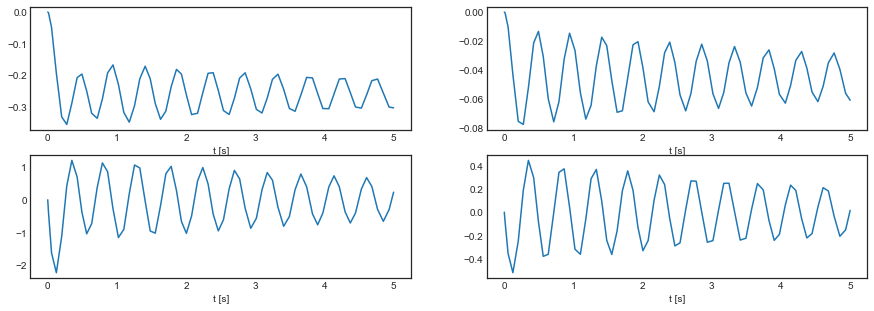

In [9]:
yi = yData.y
t = yData.t

plt.style.use('seaborn-white')

  
fig, axes = plt.subplots(2,int(len(yi)/2),figsize=(15,5))

for i in range(int(len(yi)/2)):
    # pos plot
    axes[0][i].plot(t,yi[i*2])
    axes[0][i].set_ylabel('')
    axes[0][i].set_xlabel('t [s]')
    
    # vel plot
    axes[1][i].plot(t,yi[i*2+1])
    axes[1][i].set_ylabel('')
    axes[1][i].set_xlabel('t [s]')

## Create the linearised EoM about some Stationary point

In [10]:
# Linearise the Symbolic model# Linearise the Symbolic model
p.fp.value = [0,0,0,0]
#sm_subbed = sm.linearise(p)
#sm_subbed

# sub in functions!
sm_subbed = sm.subs(p,{p.alpha_1:p.alpha_1.value,p.alphadot_1:p.alphadot_1.value})

# get the linearised sm
sm_lin = sm_subbed.linearise(p)

# sub in all but velocity
sm_reduced = sm_lin.subs(p,p.GetSubs(0,p.fp,ignore=[p.V,p.fp]))

# get eigen Matrices and turn into a function
K,M = sm_reduced.eigenMatrices(p)

func = sym.lambdify((p.V,p.fp),(K,M),'numpy')

In [11]:
from scipy.linalg import eig
ev,evec = eig(*func(0,[1.57,0,0,0]))
np.abs(ev)/(2*np.pi)
np.real(ev)

array([0., 0., 0., 0.])

In [15]:
def objective(p0):
    v0 = np.zeros_like(p0)
    y_f = [j for i in range(len(p0)) for j in [p0[i],v0[i]]]
    res = sm.deriv(0,y_f,p.GetNumericTuple(y_f,0))
    return sum((i**2 for i in res))
p.V.value = 0
from scipy.optimize import minimize
p0 = [0]*p.qs
p0[0] = np.pi/2
res = minimize(objective,p0,tol=1e5)
res.x

array([1.57079633, 0.        ])

In [24]:
df = pd.DataFrame(columns=['v','aoa','q','Lambda'])
p.alpha_r.value = np.deg2rad(5)

vs = np.linspace(0,50,101)
pLast = [0]*p.qs
pLast[-1] = np.pi/2
for v in vs:
    p.V.value = v 
    pLast = minimize(objective,pLast).x
    v0 = [0]*p.qs
    y0 = [j for i in range(len(p0)) for j in [pLast[i],v0[i]]]
    df = df.append({'aoa' : np.rad2deg(p.alpha_r.value), 'v' : v,'q':y0,'Lambda':np.rad2deg(p.Lambda.value)} , ignore_index=True)
    pLast
data = df

flutdfv2 = pd.DataFrame() 
for i in range(0,len(data)):  
    # get the fixed point
    #lp = [data['eta'].iloc[i],0,data['q1'].iloc[i],0]

    # get the jacobian evaluated at this point
    #j_lp = func(data['v'].iloc[i],np.deg2rad(data['Lambda'].iloc[i]),ratio,lp)
    # get eigen value information
    #jac_dat = dof2.ExtractEigenValueData(j_lp,sortby='Damping')
    evals, evecs = eig(*func(data['v'].iloc[i],data['q'].iloc[i]))
    jac_dat = mf.ExtractEigenValueData(evals,evecs,sortby='Frequency')

    # populate test specific data   
    jac_dat['V'] = data['v'].iloc[i]
    #jac_dat['Mass Ratio'] = f'r = {ratio}'
    y = np.array(data['q'].iloc[i])
    for i in range(len(y)):
        jac_dat[f'q_{i}'] =y[i]
    jac_dat['Lambda'] = data['Lambda'].iloc[i]
    flutdfv2 = flutdfv2.append(jac_dat,sort=False)
        
flutdfv2 = flutdfv2.reset_index(drop=True)
flutdfv2   

,cn,Real,Imag,Frequency,Damping,Stable,Eigen Vector,Mode,V,q_0,q_1,q_2,q_3,Lambda
0,0.000000+4.429447j,0.000000e+00,4.429447,0.704968,6.123234e-17,True,"[-0.22021944790965522j, 1.8528386136832516e-11...",0,0.0,1.570796,0.0,-0.062123,0.0,10.0
1,0.000000+12.566371j,0.000000e+00,12.566371,2.000000,6.123234e-17,True,"[-1.074365403398202e-09j, -0.07932669684365852...",1,0.0,1.570796,0.0,-0.062123,0.0,10.0
2,-0.048106+4.428283j,-4.810564e-02,4.428283,0.704825,-1.086263e-02,True,"[(0.0023926258470525134+0.22024914502287135j),...",0,0.5,1.569914,0.0,-0.062123,0.0,10.0
3,-0.000000+12.566372j,-4.125199e-09,12.566372,2.000000,-3.282729e-10,True,[(1.735910241995029e-07-0.00015989906658897614...,1,0.5,1.569914,0.0,-0.062123,0.0,10.0
4,-0.096211+4.424800j,-9.621126e-02,4.424800,0.704395,-2.173850e-02,True,"[(0.004790944000194303+0.22033782794575135j), ...",0,1.0,1.567261,0.0,-0.062122,0.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197,-5.780682+12.562826j,-5.780682e+00,12.562826,2.200952,-4.180119e-01,False,"[(0.030858557373175187+0.06491813829254327j), ...",1,49.0,-0.364119,0.0,-0.045849,0.0,10.0
198,0.585174+13.084862j,5.851743e-01,13.084862,2.084602,4.467682e-02,False,"[(0.06417776101308723-0.032468451859488275j), ...",0,49.5,-0.366271,0.0,-0.045876,0.0,10.0
199,-5.850461+12.673378j,-5.850461e+00,12.673378,2.221580,-4.191296e-01,False,"[(0.030653842774334653+0.06427733085444651j), ...",1,49.5,-0.366271,0.0,-0.045876,0.0,10.0
200,0.601840+13.098363j,6.018401e-01,13.098363,2.086869,4.589930e-02,False,"[(0.06445430268380263-0.031565927255686445j), ...",0,50.0,-0.368355,0.0,-0.045902,0.0,10.0


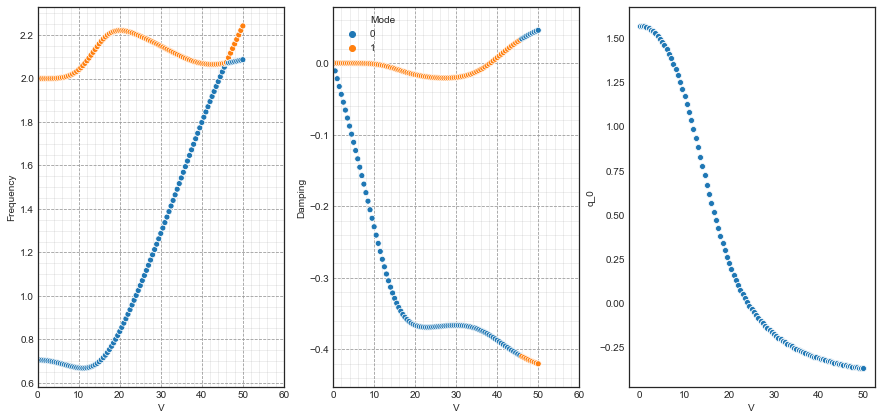

In [25]:
#data = flutdf[(flutdf['aoa']==5) & (flutdf['Damping']<0)]
#data = flutdfv2[(flutdfv2['Stable'])]
#data = flutdfv2[flutdfv2['Lambda']==10]
data = flutdfv2
fig, axes = plt.subplots(1,3,figsize=(15,7))


sns.scatterplot(data=data,x='V',y='Frequency',hue='Mode',ax=axes[0],legend=False)
sns.scatterplot(data=data,x='V',y='Damping',hue='Mode',ax=axes[1])
sns.scatterplot(data=data,x='V',y='q_0',ax=axes[2])


#axes[1].annotate('Flutter Speed Constant',xy=(41, -0.01),  xycoords='data',
#            xytext=(40, -0.1),
#            arrowprops=dict(facecolor='black', shrink=0.01,width=1))

#axes[1].annotate('Below flutter speed FWTD stabilises \nthe other mode',xy=(30, -0.05),  xycoords='data',
#            xytext=(20, -0.18),
#            arrowprops=dict(facecolor='black', shrink=0.01,width=1))

#axes[1].annotate('Instability has a peak, and its magnitude is a function of mass ratio and flare angle ',xy=(40, 0.2),  xycoords='data',
#            xytext=(-3.5, 0.25),
#            arrowprops=dict(facecolor='black', shrink=0.01,width=1))

#sns.scatterplot(data=data,x='V',y='Damping',hue='Mass Ratio',style='Lambda',ax=axes[1],s=10,edgecolor = 'none')
for i in [0,1]:
    #axes[i].set(xlim=(0,60))
    axes[i].grid(b=True, which='major', color='#999999', linestyle='--')
    axes[i].minorticks_on()
    axes[i].grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    axes[i].set(xlim=(0,60))
#axes[0].set(ylim=(0.5,3))